In [36]:
# import library and load dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# load datasetp
data_path = '../../data/processed/data_cleaned_scaled_onehot.csv' 
data = pd.read_csv(data_path)

# form features and target
X = data.drop(['Target'], axis=1)
y = data['Target']

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# hyperparameter search for SVM
from sklearn.svm import SVC

svc = SVC(class_weight='balanced')
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'sigmoid']}
# scoring on both accuracy and recall
grid = GridSearchCV(svc, param_grid, refit=True, scoring='balanced_accuracy', verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
gscore = grid.score(X_test, y_test)
print(gscore)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=100, class_weight='balanced', gamma=0.0001)
0.8442554114480212


In [38]:
# use cross validation to evaluate model consistency on X_train_scaled data
from sklearn.svm import SVC

svm = SVC(kernel='rbf', gamma=0.01, C=10, random_state=42, class_weight='balanced')
scores = cross_val_score(svm, X_train, y_train, cv=10, scoring='recall')
print("recall mean:", scores.mean(), "recall std:", scores.std())

scores = cross_val_score(svm, X_train, y_train, cv=10, scoring='accuracy')
print("accuracy mean:", scores.mean(), "accuracy std:", scores.std())

recall mean: 0.8098443898443899 recall std: 0.03941706895131469
accuracy mean: 0.8688929434548103 accuracy std: 0.00984112498834708


In [39]:
# classification with kernel svm

from sklearn.metrics import confusion_matrix

classifier = SVC(kernel='rbf', gamma=0.01, C=10, random_state=42, class_weight='balanced')
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

# accuracy, precision, recall, f1 score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("")
print("Confusion Matrix: [TP, FP], [FN, TN]")
print(cm)

Accuracy: 0.8621468926553673
Precision: 0.8129032258064516
Recall: 0.7974683544303798
F1 Score: 0.805111821086262

Confusion Matrix: [TP, FP], [FN, TN]
[[511  58]
 [ 64 252]]


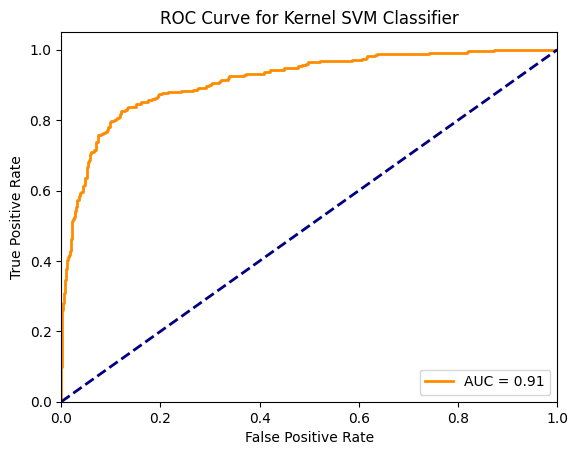

In [40]:
# roc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_test_proba = classifier.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
# auc
from sklearn.metrics import auc

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curve for Kernel SVM Classifier')
plt.legend(loc="lower right")
plt.show()


In [49]:
# I can also increase recall by lowering the decision threshold
decision_threshold = -0.5
y_pred = y_test_proba > decision_threshold
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

Accuracy: 0.8327683615819209
Precision: 0.723404255319149
Recall: 0.8607594936708861
F1 Score: 0.7861271676300579
